# Notebook per eliminare picchi

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, SecondLocator, DateFormatter
import pandas as pd
from numpy import loadtxt
pd.options.mode.chained_assignment = None  # default='warn'

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm

## Celle da modificare prima di compilare

In [40]:
# Data e ora, azimuth

data_1 = '2023-01-22 '    # ricordarsi di lasciare spazio finale
data_2 = '2023-01-22 '    # data giorno successivo se puntamento si trova a cavallo tra due giorni
ora_i = '00:00:00'
ora_f = '02:56:00'
ora_m = '03:56:00'

azimuth = 90

In [41]:
# percorsi file

file_parabola = 'dati/2023_01_22.txt'
file_ricevitore = 'dati/2023-01-21_22.txt'

## Compilazione

In [42]:
azimuth_min = azimuth - 0.1
azimuth_max = azimuth + 0.1

data_i = pd.to_datetime(data_1 + ora_i, format = '%Y-%m-%d %H:%M:%S')
data_f = pd.to_datetime(data_1 + ora_f, format = '%Y-%m-%d %H:%M:%S')
data_m = pd.to_datetime(data_1 + ora_m, format = '%Y-%m-%d %H:%M:%S')

title = data_1 + ' azimuth: ' + str(azimuth)

In [43]:
# parametri calibrazione

zero_base = 5664    # se prima del 4 marzo
# zero_base = 4450    # se dopo 4 marzo
G = 59.45866297251595
offset = 3.507669009169679*zero_base
t_rif = 365.6738767503472

In [44]:
# apertura file parabola e ricevitore e intervalli senza picchi

parabola = pd.read_csv (file_parabola,
                           sep=';',
                           header=None,
                           comment='#')

ricevitore_10 = pd.read_csv (file_ricevitore,
                                sep = ' ',
                                header=None,
                                skiprows=11,
                                decimal='.',
                                names=['data','ora','rad','temperatura'])

ora_intervalli = np.loadtxt("dati/ora_intervalli.txt", dtype= 'str')

In [45]:
# conversione rad in kelvin

ricevitore_10.rad = ((ricevitore_10.rad + offset)/G) - t_rif

In [46]:
parabola.rename(columns={0: 'day', 1: 'month', 2: 'year', 3: 'hour', 4: 'minute', 5: 'second', 9: 'azimuth', 10: 'elevazione'}, inplace = True)
parabola['data_ora'] = pd.to_datetime(parabola[["day", "month", "year", "hour", "minute", "second"]])
parabola = parabola.loc[:,['data_ora','elevazione','azimuth']]

In [47]:
while parabola.at[0,'elevazione'] > 20.1:
    parabola = parabola.drop(labels=0, axis=0)
    parabola.reset_index(inplace=True, drop=True)

In [48]:
ricevitore_10['data_ora'] = ricevitore_10['data'].map(str) + ' ' + ricevitore_10['ora'].map(str)
ricevitore_10['data_ora'] = pd.to_datetime(ricevitore_10['data_ora'], format = '%m/%d/%Y %H:%M:%S.%f')
ricevitore_10 = ricevitore_10.iloc[:,[-1,2,3]]

In [49]:
delta_time = pd.Timedelta(hours = 1)

In [50]:
mask_azimuth = (parabola.azimuth >= azimuth_min) & (parabola.azimuth <= azimuth_max)    # mask azimuth corretto

mask_ora_up = (parabola.data_ora >= data_i) & (parabola.data_ora <= data_m - 2*delta_time)  # mask orario corretto fase salita

mask_ora_down = (parabola.data_ora >= data_m - 2*delta_time) & (parabola.data_ora <= data_f)    # mask orario corretto fase discesa

In [51]:
grafico_totale = pd.DataFrame()

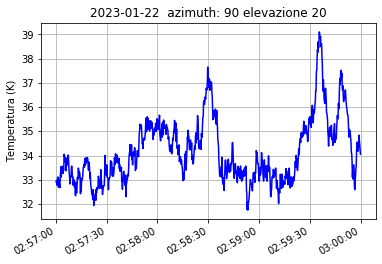

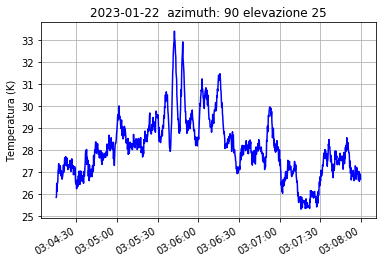

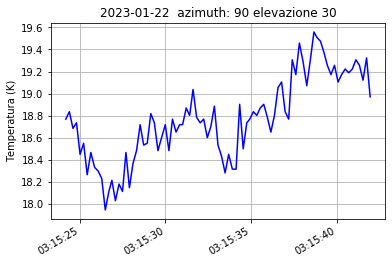

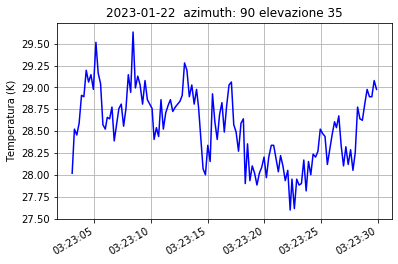

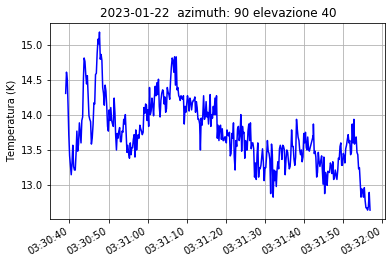

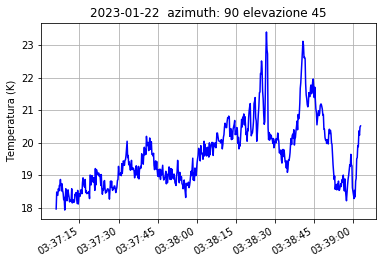

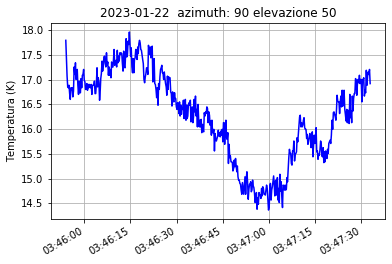

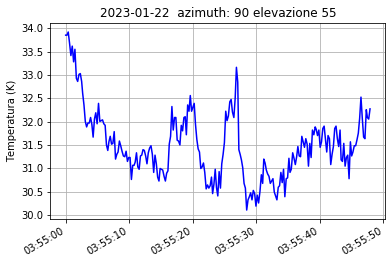

In [52]:
# salita

j = 0 # indice intervalli ritaglio
media_1 = []
dev_1 = []


for i in range (20,56,5): 
    
    mask_elevazione = (parabola.elevazione >= i - 0.3) & (parabola.elevazione <= i + 0.3)   # mask elevazione

    up_parabola = parabola.loc[mask_azimuth & mask_elevazione & mask_ora_up]
    up_parabola.reset_index(inplace=True, drop=True)

    up_parabola['data_ora'] = up_parabola.data_ora + 2*delta_time

    if (ora_intervalli[j] >= '21:00:00') & (ora_intervalli[j] <= '23:59:59'):
        data = data_1
    else: 
        data = data_2

    mask_intervalli = (up_parabola.data_ora >= data + ora_intervalli[j]) & (up_parabola.data_ora <= data + ora_intervalli[j+1])
    up_parabola = up_parabola.loc[mask_intervalli]

    mask_1 = ricevitore_10.data_ora >= up_parabola.iloc[0]['data_ora'] - delta_time
    mask_2 = ricevitore_10.data_ora <= up_parabola.iloc[-1]['data_ora'] - delta_time
    up_ricevitore_10 = ricevitore_10[mask_1 & mask_2]
    up_ricevitore_10['data_ora'] = up_ricevitore_10.data_ora + delta_time

    grafico_totale = pd.concat([grafico_totale, up_ricevitore_10])
    media_up = [up_ricevitore_10.rad.mean()]
    dev_up = [up_ricevitore_10.rad.std()]

    media_1 = media_1 + media_up
    dev_1 = dev_1 + dev_up
    
    # grafici 

    fig, ax = plt.subplots()
    fig.autofmt_xdate()

    ax.plot(up_ricevitore_10['data_ora'],up_ricevitore_10['rad'], 'b', label='temp')
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    # ax.xaxis.set_major_locator(SecondLocator(interval = 10))

    plt.title(title + ' elevazione ' + str(i))
    plt.ylabel('Temperatura (K)')
    plt.grid()
    # plt.savefig('grafici/salita_' + str(i), dpi=300)

    j+=4

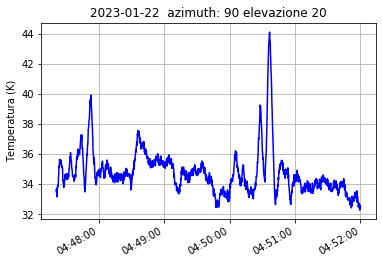

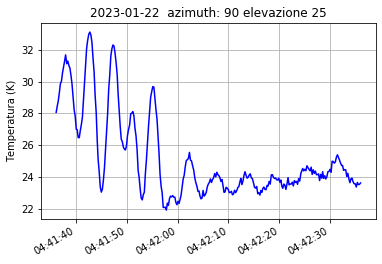

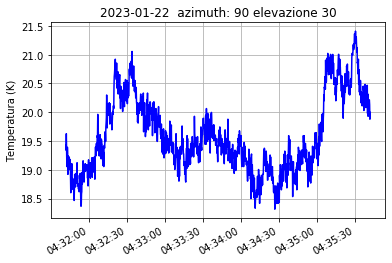

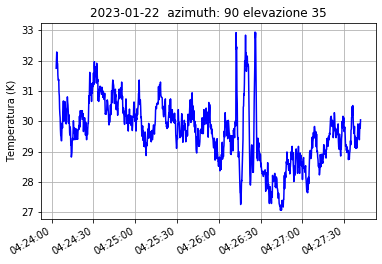

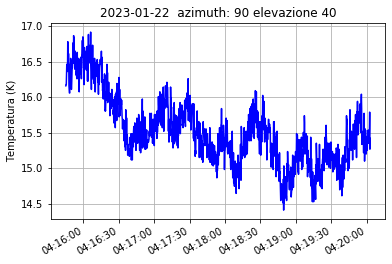

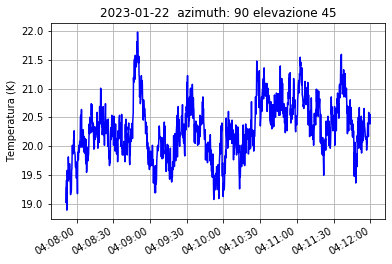

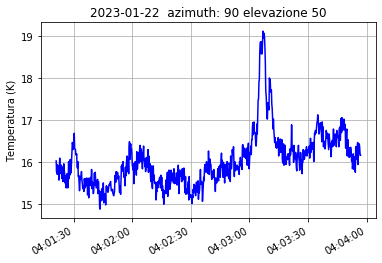

In [53]:
# discesa 

j = 0 # indice intervalli ritaglio
media_2 = []
dev_2 = []

for i in range (20, 51, 5): # fase discesa

        mask_elevazione = (parabola.elevazione >= i - 0.3) & (parabola.elevazione <= i + 0.3)   # mask elevazione
        
        down_parabola = parabola.loc[mask_azimuth & mask_elevazione & mask_ora_down]
        down_parabola.reset_index(inplace=True, drop=True)

        down_parabola['data_ora'] = down_parabola.data_ora + 2*delta_time

        if (ora_intervalli[j+2] >= '21:00:00') & (ora_intervalli[j+2] <= '23:59:59'):
                data = data_1
        else: 
                data = data_2

        mask_intervalli = (down_parabola.data_ora >= data + ora_intervalli[j+2]) & (down_parabola.data_ora <= data + ora_intervalli[j+3])
        down_parabola = down_parabola.loc[mask_intervalli]

        mask_3 = ricevitore_10.data_ora >= down_parabola.iloc[0]['data_ora'] - delta_time
        mask_4 = ricevitore_10.data_ora <= down_parabola.iloc[-1]['data_ora'] - delta_time
        down_ricevitore_10 = ricevitore_10[mask_3 & mask_4]
        down_ricevitore_10['data_ora'] = down_ricevitore_10.data_ora + delta_time

        grafico_totale = pd.concat([grafico_totale, down_ricevitore_10])
        media_down = [down_ricevitore_10.rad.mean()]
        dev_down = [down_ricevitore_10.rad.std()]

        media_2 = media_2 + media_down
        dev_2 = dev_2 + dev_down

        # grafici

        fig, ax = plt.subplots()
        fig.autofmt_xdate()

        ax.plot(down_ricevitore_10['data_ora'],down_ricevitore_10['rad'], 'b', label='temp')
        ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
        # ax.xaxis.set_major_locator(SecondLocator(interval = 10))

        plt.title(title + ' elevazione ' + str(i))
        plt.ylabel('Temperatura (K)')
        plt.grid()
        # plt.savefig('grafici/discesa_' + str(i), dpi=300)

        j+=4

In [54]:
x = [-70,-65,-60,-55,-50,-45,-40,-35]
y = [35,40,45,50,55,60,65]

# trasformo in radianti

x = [(valore*np.pi)/180 for valore in x]
y = [(valore*np.pi)/180 for valore in y]
z = (0.3*np.pi)/180

tot = []

for i in range(0,len(media_1), 1): 
    tot.append([x[i],media_1[i],z,dev_1[i]])

for i in range(0,len(media_2), 1): 
    tot.append([y[i],media_2[len(media_2)-1 -i],z,dev_2[len(media_2)-1-i]])

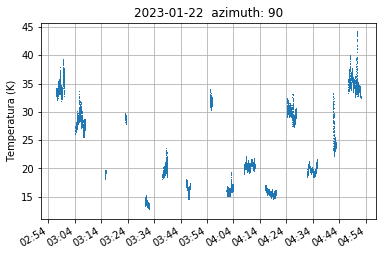

In [55]:
# grafico totale senza picchi

fig, ax = plt.subplots()
fig.autofmt_xdate()

ax.plot(grafico_totale['data_ora'],grafico_totale['rad'], ',', label='temp')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(MinuteLocator(interval = 10))

plt.title(title)
plt.ylabel('Temperatura (K)')
plt.grid()
# plt.savefig('grafici/discesa_' + str(i), dpi=300)

Text(0.5, 1.0, 'Grafico senza picchi')

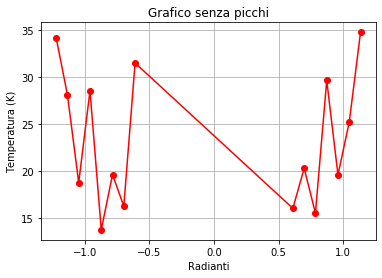

In [56]:
tot = pd.DataFrame(tot, columns= ['Elevazione', 'Temperatura', 'Errore elevazione','Errore temperatura'])

plt.plot(tot['Elevazione'], tot['Temperatura'], 'or-') 
plt.grid()
plt.ylabel('Temperatura (K)')
plt.xlabel('Radianti')
plt.title ('Grafico senza picchi')

In [57]:
np.savetxt('fit.txt', tot.values, fmt='%f')